In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

from skimage.segmentation import slic
from skimage.data import astronaut
from skimage.segmentation._slic import  _slic_cython, _enforce_label_connectivity_cython
import numpy as np

import collections as coll
import numpy as np
from scipy import ndimage as ndi

from skimage.util import img_as_float, regular_grid
from skimage.color import rgb2lab
from tqdm import tqdm_notebook as tqdm

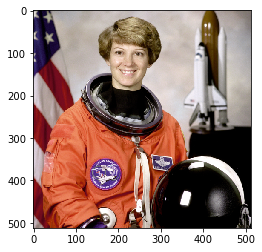

In [2]:
raw_img = astronaut()

plt.imshow(raw_img)

In [3]:
#------ Hyper Parameter Setting ------#
n_segments=100
compactness=10.
max_iter=10   
spacing = np.ones(2)
#---------------------------------------------#

image = img_as_float(raw_img)
image = rgb2lab(raw_img)

height, width = image.shape[:2]

# initialize cluster centroids for desired number of segments
grid_y, grid_x = np.mgrid[:height, :width]
slices = regular_grid(image.shape[:2], n_segments)
step_y, step_x = [int(s.step if s.step is not None else 1)
                          for s in slices]

segments_y = grid_y[slices]
segments_x = grid_x[slices]

segments_color = np.zeros(segments_y.shape + (image.shape[2], ))
segments = np.concatenate([
                           segments_y[..., np.newaxis],
                           segments_x[..., np.newaxis],
                           segments_color],
                          axis=-1).reshape(-1, 2 + image.shape[2])
segments = np.ascontiguousarray(segments)

# we do the scaling of ratio in the same way as in the SLIC paper
# so the values have the same meaning
step = float(max(( step_y, step_x)))
ratio = 1.0 / compactness

image = np.ascontiguousarray(image * ratio)

In [4]:
n_segments = segments.shape[0]
n_features = segments.shape[1]
# approximate grid size for desired n_segments

slices = regular_grid((height, width), n_segments)

step_y, step_x = [int(s.step if s.step is not None else 1) for s in slices]

In [5]:
nearest_segments = np.empty((height, width), dtype=np.intp)
distance = np.empty((height, width), dtype=np.double)
n_segment_elems = np.zeros(n_segments, dtype=np.intp)

In [6]:
# The colors are scaled before being passed to _slic_cython so
# max_color_sq can be initialised as all ones
max_dist_color = np.ones(n_segments, dtype=np.double)
spatial_weight = float(1) / (step ** 2)

In [7]:
DBL_MAX = np.finfo(np.float64).max

In [8]:
sy = spacing[0]
sx = spacing[1]

In [9]:
for i in tqdm(range(max_iter)):
    is_changed = False
    distance[:, :] = DBL_MAX

    # assign pixels to segments
    for k in range(n_segments):

        # segment coordinate centers
        cy = segments[k, 0]
        cx = segments[k, 1]

        # compute windows
        y_min = int(max(cy - 2 * step_y, 0))
        y_max = int(min(cy + 2 * step_y + 1, height))
        x_min = int(max(cx - 2 * step_x, 0))
        x_max = int(min(cx + 2 * step_x + 1, width))

        for y in range(y_min, y_max):
            dy = (sy * (cy - y)) ** 2
            for x in range(x_min, x_max):
                dist_center = (dy + (sx * (cx - x)) ** 2) * spatial_weight
                dist_color = 0
                for c in range(2, n_features):
                    dist_color += (image[y, x, c - 2] - segments[k, c]) ** 2

                dist_center += dist_color

                if distance[y, x] > dist_center:
                    nearest_segments[y, x] = k
                    distance[y, x] = dist_center
                    is_changed = True

    # stop if no pixel changed its segment
    if not is_changed:
        break

    # recompute segment centers

    # sum features for all segments
    n_segment_elems[:] = 0
    segments[:, :] = 0

    for y in range(height):
        for x in range(width):
            k = nearest_segments[y, x]
            n_segment_elems[k] += 1
            segments[k, 0] += y
            segments[k, 1] += x
            for c in range(2, n_features):
                segments[k, c] += image[y, x, c - 2]

    # divide by number of elements per segment to obtain mean
    for k in range(n_segments):
        for c in range(n_features):
            segments[k, c] /= n_segment_elems[k]

HBox(children=(IntProgress(value=0, max=10), HTML(value=u'')))

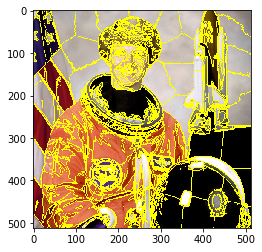

In [10]:
from skimage.segmentation import mark_boundaries
plt.imshow(mark_boundaries(raw_img, nearest_segments))